In [1]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('form5500_data/config.json') as f:
   conf = json.load(f)
   host = conf['host']
   database = conf['database']
   user = conf['user']
   passw = conf['passw']

In [3]:
conn_str = "host={} dbname={} user={} password={}".format(host, database, user, passw)

In [4]:
conn = psycopg2.connect(conn_str)

In [5]:
query = "SELECT sb.SB_TOT_PARTCP_CNT, sb.SB_EFF_INT_RATE_PRCNT, sb.SB_PLAN_YEAR_BEGIN_DATE, sb.SB_FNDNG_SHORT_IND, \
       sb.SB_PR_YR_FNDNG_PRCNT, sb.SB_FNDNG_TGT_PRCNT, sb.SB_TOT_FNDNG_TGT_AMT, sb.SB_CURR_VALUE_AST_01_AMT \
FROM sb_full sb;"

In [6]:
eda_df = pd.read_sql(query, con=conn)

In [7]:
eda_df

,sb_tot_partcp_cnt,sb_eff_int_rate_prcnt,sb_plan_year_begin_date,sb_fndng_short_ind,sb_pr_yr_fndng_prcnt,sb_fndng_tgt_prcnt,sb_tot_fndng_tgt_amt,sb_curr_value_ast_01_amt
0,3,5.26,2017-01-01,1,97.07,112.68,269963.0,304208.0
1,2,5.72,2017-01-01,2,117.40,121.43,1853763.0,2251205.0
2,6,5.72,2017-01-01,2,110.49,108.27,375766.0,406872.0
3,17,5.87,2017-01-01,1,85.28,92.24,974043.0,1220713.0
4,1,5.24,2017-01-01,1,92.60,94.72,2385087.0,2259335.0
5,2,4.16,2017-01-01,2,101.21,104.45,702486.0,733755.0
6,2,4.30,2017-01-01,2,146.27,142.65,1003627.0,1431693.0
7,2,5.72,2017-01-01,2,89.01,100.87,233957.0,236013.0
8,1,5.64,2017-01-01,1,82.17,80.00,747025.0,620933.0
9,4,5.63,2017-01-01,2,111.76,103.29,2870545.0,2965011.0


<h3>Add calculated FS (using MVA instead of AVA) column</h3>

In [8]:
eda_df['mva_fs'] = eda_df['sb_curr_value_ast_01_amt'] / eda_df['sb_tot_fndng_tgt_amt']

<h3>Add year column (year only of plan year begin date) </h3>

In [9]:
type(eda_df['sb_plan_year_begin_date'][0])

datetime.date

In [10]:
eda_df['plan_year_dt'] = pd.to_datetime(eda_df['sb_plan_year_begin_date'])

In [11]:
eda_df['year'] = eda_df['plan_year_dt'].dt.year

<h3>Create integer versions of feature columns</h3>

In [13]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223880 entries, 0 to 223879
Data columns (total 11 columns):
sb_tot_partcp_cnt           223664 non-null object
sb_eff_int_rate_prcnt       223730 non-null float64
sb_plan_year_begin_date     223880 non-null object
sb_fndng_short_ind          223413 non-null object
sb_pr_yr_fndng_prcnt        221487 non-null float64
sb_fndng_tgt_prcnt          223724 non-null float64
sb_tot_fndng_tgt_amt        223763 non-null float64
sb_curr_value_ast_01_amt    223701 non-null float64
mva_fs                      206829 non-null float64
plan_year_dt                223880 non-null datetime64[ns]
year                        223880 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 18.8+ MB


<h3>Participant count</h3>

In [14]:
eda_df['ptp_cnt'] = pd.to_numeric(eda_df['sb_tot_partcp_cnt'])

<h3>Prior year shortfall indicator</h3>

In [16]:
eda_df['sb_fndng_short_ind'].unique()

array(['1', '2', None], dtype=object)

In [17]:
eda_df['sf_ind'] = pd.to_numeric(eda_df['sb_fndng_short_ind'])
eda_df['sf_ind'] = eda_df['sf_ind'].fillna(value=0)

In [18]:
eda_df.groupby('sf_ind')['sf_ind'].count()

sf_ind
0.0       467
1.0     73546
2.0    149867
Name: sf_ind, dtype: int64

<h1>Create Features DF</h1>
<h3>Drop rows with NA</h3>

In [19]:
prelim_feat_df = eda_df[['ptp_cnt', 'sb_eff_int_rate_prcnt', 'year','sf_ind', \
                         'sb_pr_yr_fndng_prcnt', 'mva_fs', 'sb_tot_fndng_tgt_amt']]

In [20]:
prelim_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223880 entries, 0 to 223879
Data columns (total 7 columns):
ptp_cnt                  223664 non-null float64
sb_eff_int_rate_prcnt    223730 non-null float64
year                     223880 non-null int64
sf_ind                   223880 non-null float64
sb_pr_yr_fndng_prcnt     221487 non-null float64
mva_fs                   206829 non-null float64
sb_tot_fndng_tgt_amt     223763 non-null float64
dtypes: float64(6), int64(1)
memory usage: 12.0 MB


In [21]:
prelim_feat_df = prelim_feat_df.dropna(axis=0)

In [27]:
y_ava_fs = eda_df['sb_fndng_tgt_prcnt'].values
y_fs = prelim_feat_df['mva_fs'].values
y_ft = prelim_feat_df['sb_tot_fndng_tgt_amt'].values

In [23]:
X = prelim_feat_df[['ptp_cnt', 'sb_eff_int_rate_prcnt', 'year','sf_ind', \
                         'sb_pr_yr_fndng_prcnt']]

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205677 entries, 0 to 223879
Data columns (total 5 columns):
ptp_cnt                  205677 non-null float64
sb_eff_int_rate_prcnt    205677 non-null float64
year                     205677 non-null int64
sf_ind                   205677 non-null float64
sb_pr_yr_fndng_prcnt     205677 non-null float64
dtypes: float64(4), int64(1)
memory usage: 9.4 MB


<h1>Features EDA</h1>

In [ ]:
from pandas.plotting import scatter_matrix

In [ ]:
scatter_matrix(prelim_feat_df, alpha=0.6, figsize=(12, 12), diagonal='kde')
plt.show()

In [31]:
np.min(eda_df['sb_curr_value_ast_01_amt'])

-38622.0

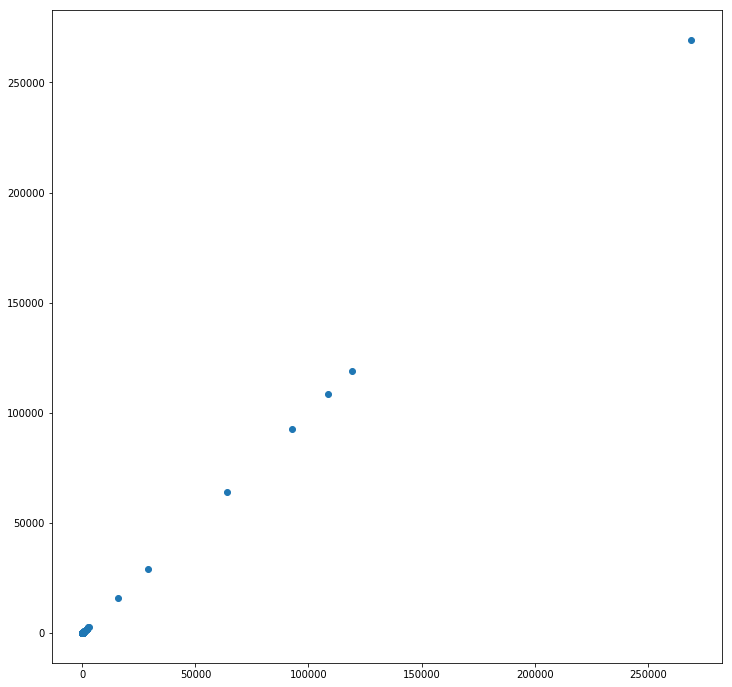

In [29]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
#plt.scatter(X['sb_pr_yr_fndng_prcnt'], y_fs)
plt.scatter(y_fs, y_fs)
plt.show()